In [3]:
## Import
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Module containing custom functions
import models.data as mdt
import models.report as rpt

# Remove warnings display
import warnings
warnings.filterwarnings('ignore')

# Fix issue with libomp conflicts
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [5]:
# Load data and display head
trip_data_df = mdt.load_dataset_as_dataframe('data/trip-data/processed-data')

In [6]:
# Removes outliers from dataset
cleaned_df = trip_data_df[trip_data_df.speed > -10 ][trip_data_df.car_accel > -10]

In [7]:
# Extracting braking events
braking_entries_df = mdt.filter_acceleration_entries(cleaned_df, threshold=-2, above=False)
braking_events = mdt.extract_events(braking_entries_df)

In [8]:
# Calculate braking events metrics
braking_event_metrics_df = mdt.get_events_metrics(braking_events)

In [9]:
# Import models
from models.pipeline import BasePipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict

In [21]:
# Extract features / target data
y = braking_event_metrics_df.driver_rush
X = braking_event_metrics_df.drop(columns=['driver_rush'])

In [22]:
# Train  Test Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

Tested Model:  lr


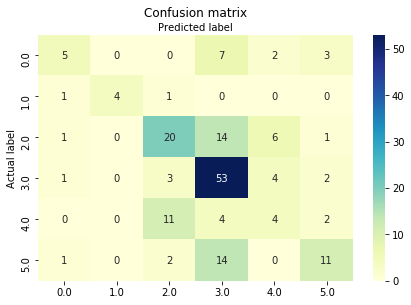

              precision    recall  f1-score   support

         0.0       0.56      0.29      0.38        17
         1.0       1.00      0.67      0.80         6
         2.0       0.54      0.48      0.51        42
         3.0       0.58      0.84      0.68        63
         4.0       0.25      0.19      0.22        21
         5.0       0.58      0.39      0.47        28

   micro avg       0.55      0.55      0.55       177
   macro avg       0.58      0.48      0.51       177
weighted avg       0.54      0.55      0.53       177



Tested Model:  dt_cls


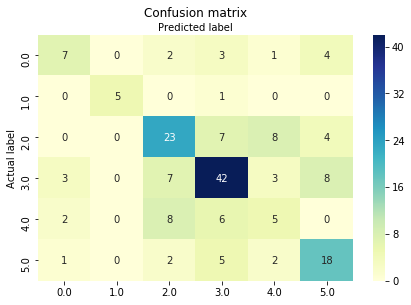

              precision    recall  f1-score   support

         0.0       0.54      0.41      0.47        17
         1.0       1.00      0.83      0.91         6
         2.0       0.55      0.55      0.55        42
         3.0       0.66      0.67      0.66        63
         4.0       0.26      0.24      0.25        21
         5.0       0.53      0.64      0.58        28

   micro avg       0.56      0.56      0.56       177
   macro avg       0.59      0.56      0.57       177
weighted avg       0.56      0.56      0.56       177



Tested Model:  rf_clf


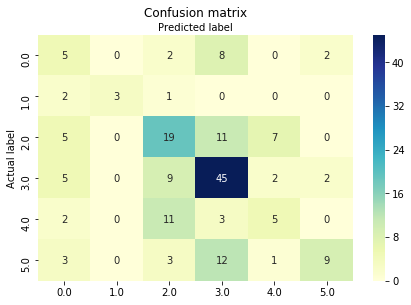

              precision    recall  f1-score   support

         0.0       0.23      0.29      0.26        17
         1.0       1.00      0.50      0.67         6
         2.0       0.42      0.45      0.44        42
         3.0       0.57      0.71      0.63        63
         4.0       0.33      0.24      0.28        21
         5.0       0.69      0.32      0.44        28

   micro avg       0.49      0.49      0.49       177
   macro avg       0.54      0.42      0.45       177
weighted avg       0.51      0.49      0.48       177



Tested Model:  adaboost_clf


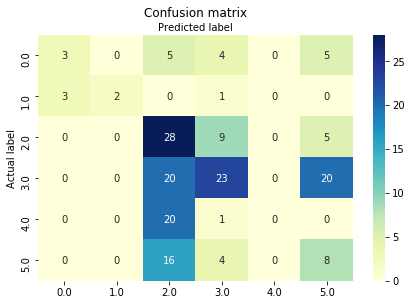

              precision    recall  f1-score   support

         0.0       0.50      0.18      0.26        17
         1.0       1.00      0.33      0.50         6
         2.0       0.31      0.67      0.43        42
         3.0       0.55      0.37      0.44        63
         4.0       0.00      0.00      0.00        21
         5.0       0.21      0.29      0.24        28

   micro avg       0.36      0.36      0.36       177
   macro avg       0.43      0.30      0.31       177
weighted avg       0.38      0.36      0.34       177



Tested Model:  knn_clf


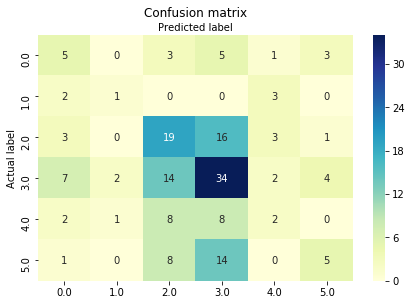

              precision    recall  f1-score   support

         0.0       0.25      0.29      0.27        17
         1.0       0.25      0.17      0.20         6
         2.0       0.37      0.45      0.40        42
         3.0       0.44      0.54      0.49        63
         4.0       0.18      0.10      0.12        21
         5.0       0.38      0.18      0.24        28

   micro avg       0.37      0.37      0.37       177
   macro avg       0.31      0.29      0.29       177
weighted avg       0.36      0.37      0.35       177



Tested Model:  xgb_clf


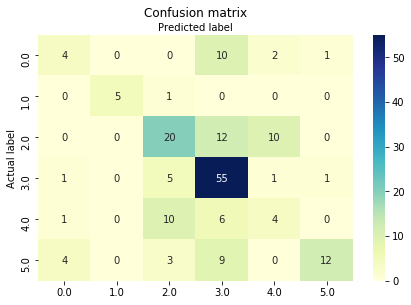

              precision    recall  f1-score   support

         0.0       0.40      0.24      0.30        17
         1.0       1.00      0.83      0.91         6
         2.0       0.51      0.48      0.49        42
         3.0       0.60      0.87      0.71        63
         4.0       0.24      0.19      0.21        21
         5.0       0.86      0.43      0.57        28

   micro avg       0.56      0.56      0.56       177
   macro avg       0.60      0.51      0.53       177
weighted avg       0.57      0.56      0.54       177



Tested Model:  sv_clf


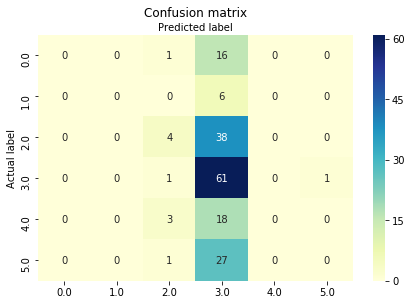

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        17
         1.0       0.00      0.00      0.00         6
         2.0       0.40      0.10      0.15        42
         3.0       0.37      0.97      0.53        63
         4.0       0.00      0.00      0.00        21
         5.0       0.00      0.00      0.00        28

   micro avg       0.37      0.37      0.37       177
   macro avg       0.13      0.18      0.11       177
weighted avg       0.23      0.37      0.23       177





In [23]:
# Bellow, we train our pre-selected baseline models on our train dataset and display the scoring output.
tested_models = {
    'lr': LogisticRegression(),
    'dt_cls': DecisionTreeClassifier(),
    'rf_clf': RandomForestClassifier(),
    'adaboost_clf': AdaBoostClassifier(),
    'knn_clf': KNeighborsClassifier(),
    'xgb_clf': XGBClassifier(),
    'sv_clf': SVC()
}

for model in tested_models:
    pipe = BasePipeline(tested_models[model])
    pipe.fit(X_train, y_train)

    y_hat_test = pipe.predict(X_test)

    print('======================')
    print('Tested Model: ', model)
    print('======================')
    rpt.print_confusion_matrix(y_test, y_hat_test)
    print('\n')


**Observations** : The results don't look promising. Our best baseline model XGB Classifier reached a F1 score ~54% and Accuracy ~57%

**Transforming the classification into a binary classification**

In [26]:
# Changing target values to have a binary classifier
binary_y = y >= 3
binary_y = binary_y.astype(int)

# Train  Test Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, binary_y, test_size=.3, random_state=42)

Tested Model:  lr


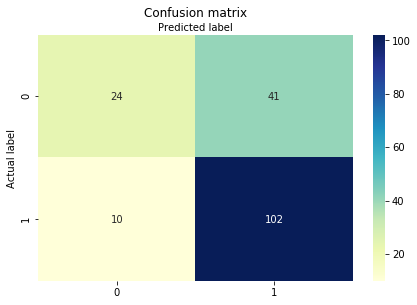

              precision    recall  f1-score   support

           0       0.71      0.37      0.48        65
           1       0.71      0.91      0.80       112

   micro avg       0.71      0.71      0.71       177
   macro avg       0.71      0.64      0.64       177
weighted avg       0.71      0.71      0.68       177



Tested Model:  dt_cls


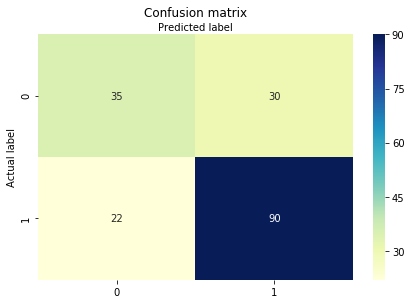

              precision    recall  f1-score   support

           0       0.61      0.54      0.57        65
           1       0.75      0.80      0.78       112

   micro avg       0.71      0.71      0.71       177
   macro avg       0.68      0.67      0.67       177
weighted avg       0.70      0.71      0.70       177



Tested Model:  rf_clf


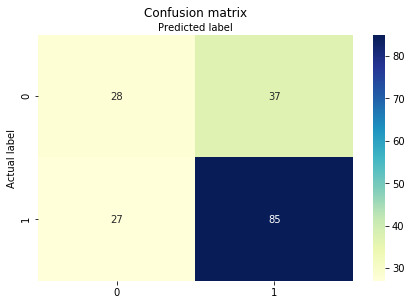

              precision    recall  f1-score   support

           0       0.51      0.43      0.47        65
           1       0.70      0.76      0.73       112

   micro avg       0.64      0.64      0.64       177
   macro avg       0.60      0.59      0.60       177
weighted avg       0.63      0.64      0.63       177



Tested Model:  adaboost_clf


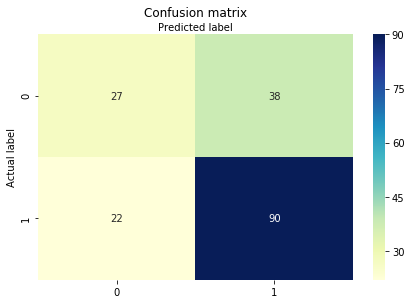

              precision    recall  f1-score   support

           0       0.55      0.42      0.47        65
           1       0.70      0.80      0.75       112

   micro avg       0.66      0.66      0.66       177
   macro avg       0.63      0.61      0.61       177
weighted avg       0.65      0.66      0.65       177



Tested Model:  knn_clf


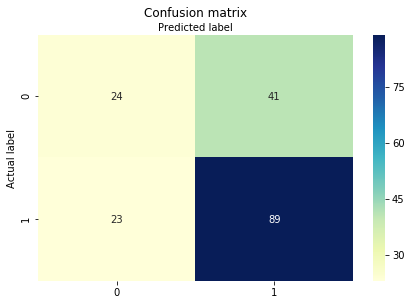

              precision    recall  f1-score   support

           0       0.51      0.37      0.43        65
           1       0.68      0.79      0.74       112

   micro avg       0.64      0.64      0.64       177
   macro avg       0.60      0.58      0.58       177
weighted avg       0.62      0.64      0.62       177



Tested Model:  xgb_clf


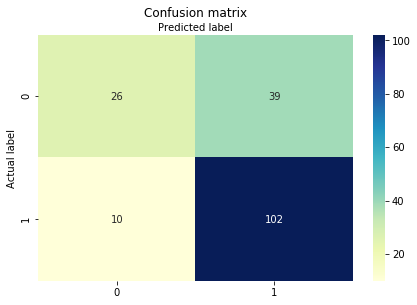

              precision    recall  f1-score   support

           0       0.72      0.40      0.51        65
           1       0.72      0.91      0.81       112

   micro avg       0.72      0.72      0.72       177
   macro avg       0.72      0.66      0.66       177
weighted avg       0.72      0.72      0.70       177



Tested Model:  sv_clf


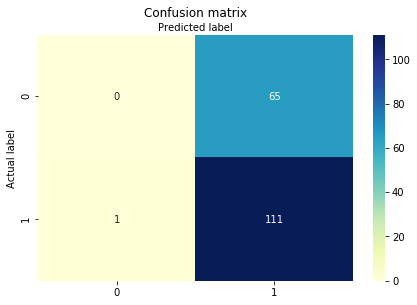

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        65
           1       0.63      0.99      0.77       112

   micro avg       0.63      0.63      0.63       177
   macro avg       0.32      0.50      0.39       177
weighted avg       0.40      0.63      0.49       177





In [39]:
tested_models = {
    'lr': LogisticRegression(),
    'dt_cls': DecisionTreeClassifier(),
    'rf_clf': RandomForestClassifier(),
    'adaboost_clf': AdaBoostClassifier(),
    'knn_clf': KNeighborsClassifier(),
    'xgb_clf': XGBClassifier(),
    'sv_clf': SVC()
}

for model in tested_models:
    pipe = BasePipeline(tested_models[model])
    pipe.fit(X_train, y_train)

    y_hat_test = pipe.predict(X_test)

    print('======================')
    print('Tested Model: ', model)
    print('======================')
    rpt.print_confusion_matrix(y_test, y_hat_test)
    print('\n')

In [38]:
# Deal with imbalance using SMOTE
from imblearn.over_sampling import SMOTE
import pandas as pd

# Smote train dataset using a 50-50 split
smote = SMOTE(sampling_strategy=1)
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)

# Transform resample X_train into DataFrame
X_train_resampled = pd.DataFrame(X_train_resampled)
X_train_resampled.columns = X.columns

Tested Model:  lr


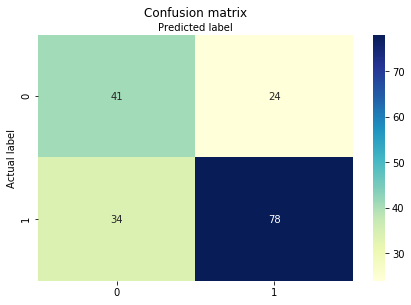

              precision    recall  f1-score   support

           0       0.55      0.63      0.59        65
           1       0.76      0.70      0.73       112

   micro avg       0.67      0.67      0.67       177
   macro avg       0.66      0.66      0.66       177
weighted avg       0.68      0.67      0.68       177



Tested Model:  dt_cls


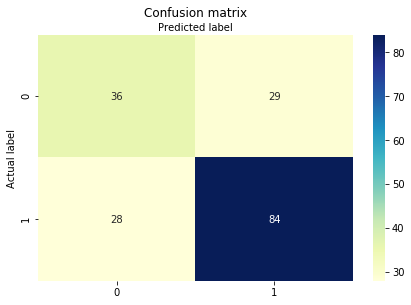

              precision    recall  f1-score   support

           0       0.56      0.55      0.56        65
           1       0.74      0.75      0.75       112

   micro avg       0.68      0.68      0.68       177
   macro avg       0.65      0.65      0.65       177
weighted avg       0.68      0.68      0.68       177



Tested Model:  rf_clf


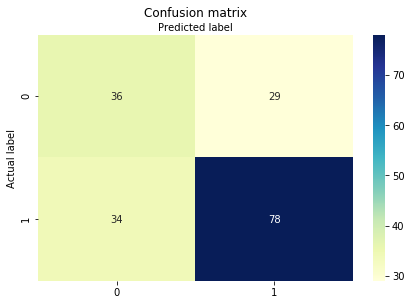

              precision    recall  f1-score   support

           0       0.51      0.55      0.53        65
           1       0.73      0.70      0.71       112

   micro avg       0.64      0.64      0.64       177
   macro avg       0.62      0.63      0.62       177
weighted avg       0.65      0.64      0.65       177



Tested Model:  adaboost_clf


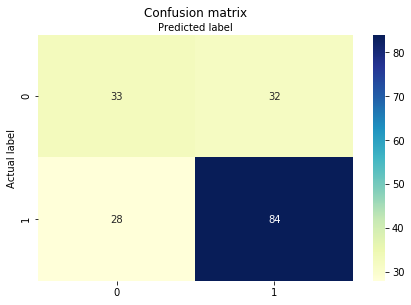

              precision    recall  f1-score   support

           0       0.54      0.51      0.52        65
           1       0.72      0.75      0.74       112

   micro avg       0.66      0.66      0.66       177
   macro avg       0.63      0.63      0.63       177
weighted avg       0.66      0.66      0.66       177



Tested Model:  knn_clf


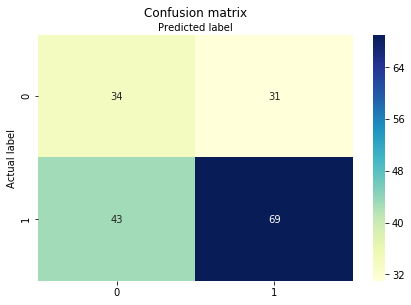

              precision    recall  f1-score   support

           0       0.44      0.52      0.48        65
           1       0.69      0.62      0.65       112

   micro avg       0.58      0.58      0.58       177
   macro avg       0.57      0.57      0.56       177
weighted avg       0.60      0.58      0.59       177



Tested Model:  xgb_clf


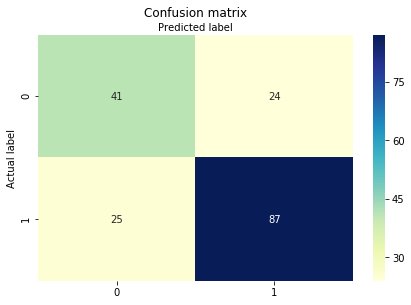

              precision    recall  f1-score   support

           0       0.62      0.63      0.63        65
           1       0.78      0.78      0.78       112

   micro avg       0.72      0.72      0.72       177
   macro avg       0.70      0.70      0.70       177
weighted avg       0.72      0.72      0.72       177



Tested Model:  sv_clf


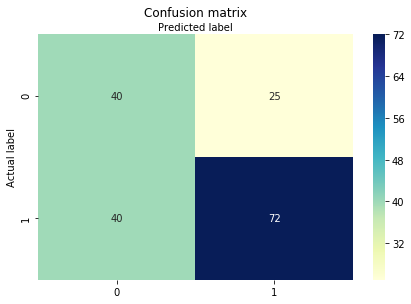

              precision    recall  f1-score   support

           0       0.50      0.62      0.55        65
           1       0.74      0.64      0.69       112

   micro avg       0.63      0.63      0.63       177
   macro avg       0.62      0.63      0.62       177
weighted avg       0.65      0.63      0.64       177





In [47]:
tested_models = {
    'lr': LogisticRegression(),
    'dt_cls': DecisionTreeClassifier(),
    'rf_clf': RandomForestClassifier(),
    'adaboost_clf': AdaBoostClassifier(),
    'knn_clf': KNeighborsClassifier(),
    'xgb_clf': XGBClassifier(),
    'sv_clf': SVC()
}

for model in tested_models:
    pipe = BasePipeline(tested_models[model])
    pipe.fit(X_train_resampled, y_train_resampled)

    y_hat_test = pipe.predict(X_test)

    print('======================')
    print('Tested Model: ', model)
    print('======================')
    rpt.print_confusion_matrix(y_test, y_hat_test)
    print('\n')

**Observations** : We can see a small improve in F1 score for the XGB Classifier

### Hyper-parameters tuning step

In the following steps, we are going to use GridSearchCV class in order to perform our hyper-parameters tuning step.

#### LXGBoost Model

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV

param_grid = {
    'lr__penalty': ['l1', 'l2'],
    'lr__C': np.logspace(0, 4, 10)
}

pipe = Pipeline([
    ('features', features),
    ('lr', LogisticRegression())
])

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring='recall')

clf.fit(X_train_resampled, y_train_resampled)

print(clf.best_params_)
y_hat_test = clf.predict(X_test)

print('======================')
print('Tested Model: ', 'LogReg')
print('======================')
print(classification_report(y_test, y_hat_test))
print_confusion_matrix(y_test, y_hat_test)
print('\n')


In [48]:
model = XGBClassifier()

In [49]:
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]
%time model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.766095	validation_0-error:0.258537	validation_1-auc:0.646429	validation_1-error:0.384181
[1]	validation_0-auc:0.783978	validation_0-error:0.263415	validation_1-auc:0.692376	validation_1-error:0.327684
[2]	validation_0-auc:0.790988	validation_0-error:0.263415	validation_1-auc:0.681044	validation_1-error:0.316384
[3]	validation_0-auc:0.789474	validation_0-error:0.263415	validation_1-auc:0.698352	validation_1-error:0.316384
[4]	validation_0-auc:0.790988	validation_0-error:0.263415	validation_1-auc:0.681044	validation_1-error:0.316384
[5]	validation_0-auc:0.796679	validation_0-error:0.265854	validation_1-auc:0.707212	validation_1-error:0.316384
[6]	validation_0-auc:0.794225	validation_0-error:0.265854	validation_1-auc:0.689423	validation_1-error:0.316384
[7]	validation_0-auc:0.813466	validation_0-error:0.24878	validation_1-auc:0.712088	validation_1-error:0.310734
[8]	validation_0-auc:0.820972	validation_0-error:0.239024	validation_1-auc:0.713118	validation_1-error:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

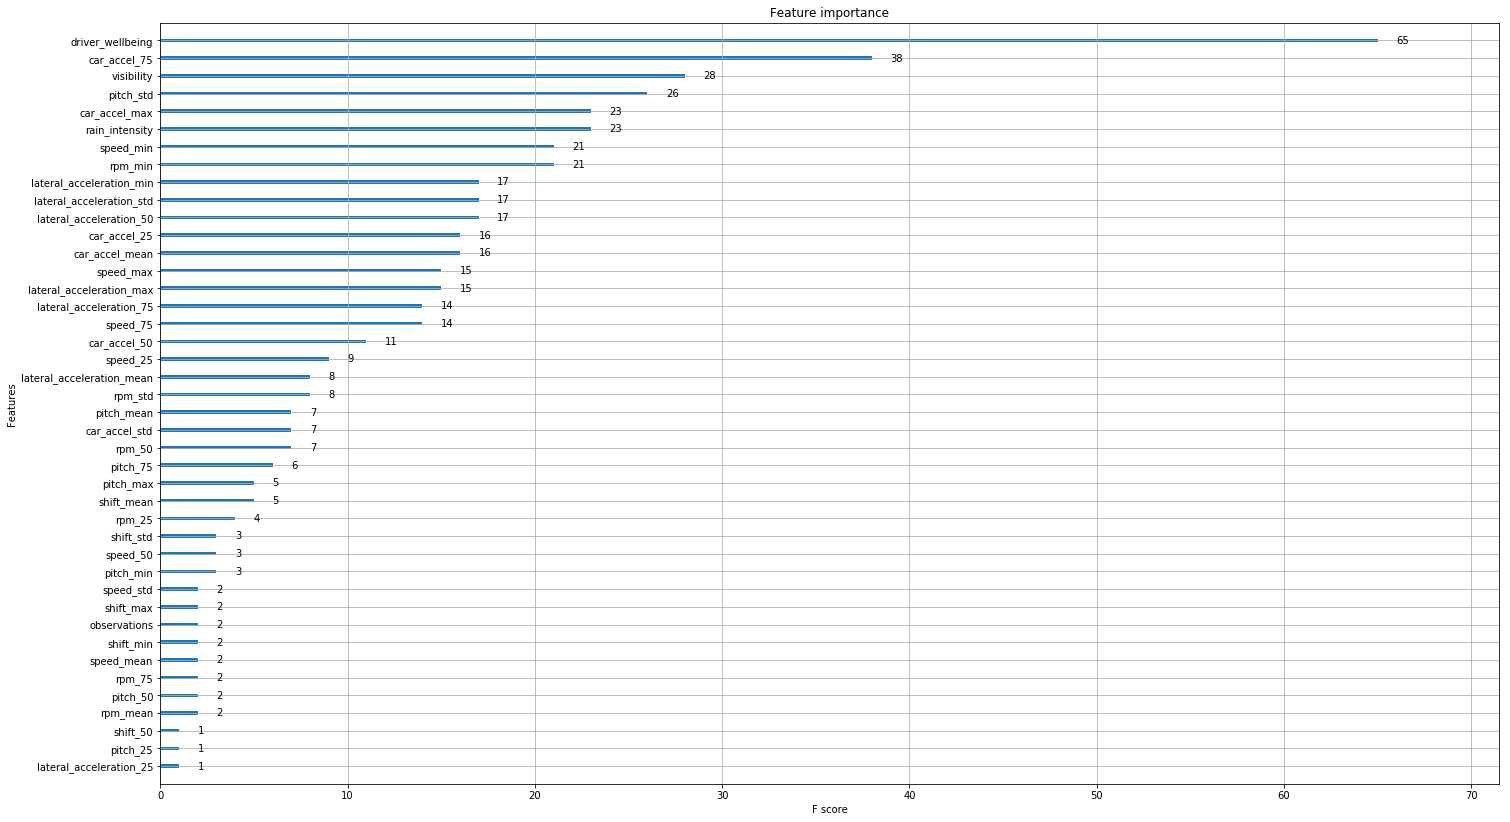

In [58]:
import xgboost
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(24,14))
xgboost.plot_importance(model, ax=ax)

In [15]:
braking_event_metrics_df.car_accel_25.quantile(.5), braking_event_metrics_df.car_accel_25.quantile(.75), braking_event_metrics_df.car_accel_25.quantile(.25)

(-2.3667249999999997, -2.1672625, -2.6719749999999998)

In [16]:
# Trying to filter down our events to use only the most extreme braking events.
car_accel_75_threshhold = braking_event_metrics_df.car_accel_25.quantile(.25)
car_accel_75_threshhold

-2.6719749999999998

In [17]:
filtered_braking_event_metrics_df = braking_event_metrics_df[braking_event_metrics_df.car_accel_25 < car_accel_75_threshhold]
filtered_braking_event_metrics_df.describe()

,observations,speed_mean,speed_std,speed_min,speed_25,speed_50,speed_75,speed_max,car_accel_mean,car_accel_std,...,shift_std,shift_min,shift_25,shift_50,shift_75,shift_max,driver_rush,visibility,rain_intensity,driver_wellbeing
count,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,...,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000
mean,228.884354,6.503445,1.661502,3.727474,5.072167,6.489946,7.967819,9.198633,-2.800681,0.424116,...,0.518516,0.088435,0.146259,0.435374,0.775510,1.414966,2.755102,9.544218,0.244898,5.918367
std,157.710525,3.442987,1.001668,3.280317,3.316646,3.526551,3.797208,4.238859,0.475052,0.213428,...,0.638134,0.481510,0.636264,1.098368,1.338553,1.543184,1.322056,0.704499,0.657849,1.392299
min,14.000000,0.350192,0.050576,-0.122930,-0.000294,0.001419,0.681545,1.018200,-6.227260,0.181109,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,2.000000
25%,108.000000,4.438014,0.873886,1.387000,2.892375,4.397200,5.695512,6.315500,-2.887778,0.294359,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,9.000000,0.000000,5.000000
50%,182.000000,5.913091,1.515614,2.601200,4.276300,5.877250,7.415000,8.526500,-2.661899,0.363621,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,10.000000,0.000000,6.000000
75%,320.000000,8.378306,2.158603,5.463150,6.664900,8.425500,9.997000,11.381000,-2.532521,0.484512,...,1.035624,0.000000,0.000000,0.000000,2.000000,3.000000,3.000000,10.000000,0.000000,7.000000
max,795.000000,18.199316,5.589902,16.577000,17.097000,18.150000,19.730500,22.336000,-2.385764,1.986340,...,1.995028,3.000000,4.000000,4.000000,4.000000,5.000000,5.000000,10.000000,3.000000,8.000000


In [18]:
# Extract features / target data
y = filtered_braking_event_metrics_df.driver_rush
X = filtered_braking_event_metrics_df.drop(columns=['driver_rush'])

In [19]:
# Train  Test Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

Tested Model:  lr


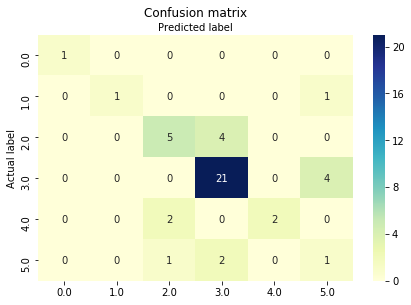

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         1
         1.0       1.00      0.50      0.67         2
         2.0       0.62      0.56      0.59         9
         3.0       0.78      0.84      0.81        25
         4.0       1.00      0.50      0.67         4
         5.0       0.17      0.25      0.20         4

   micro avg       0.69      0.69      0.69        45
   macro avg       0.76      0.61      0.65        45
weighted avg       0.73      0.69      0.70        45



Tested Model:  dt_cls


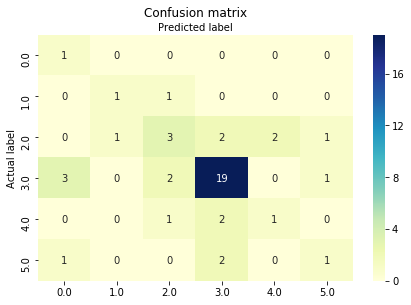

              precision    recall  f1-score   support

         0.0       0.20      1.00      0.33         1
         1.0       0.50      0.50      0.50         2
         2.0       0.43      0.33      0.38         9
         3.0       0.76      0.76      0.76        25
         4.0       0.33      0.25      0.29         4
         5.0       0.33      0.25      0.29         4

   micro avg       0.58      0.58      0.58        45
   macro avg       0.43      0.52      0.42        45
weighted avg       0.59      0.58      0.58        45



Tested Model:  rf_clf


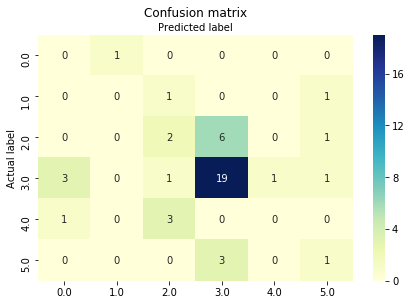

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.00      0.00      0.00         2
         2.0       0.29      0.22      0.25         9
         3.0       0.68      0.76      0.72        25
         4.0       0.00      0.00      0.00         4
         5.0       0.25      0.25      0.25         4

   micro avg       0.49      0.49      0.49        45
   macro avg       0.20      0.21      0.20        45
weighted avg       0.46      0.49      0.47        45



Tested Model:  adaboost_clf


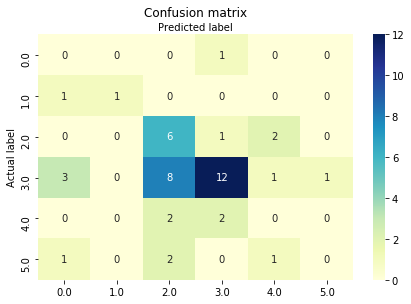

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       1.00      0.50      0.67         2
         2.0       0.33      0.67      0.44         9
         3.0       0.75      0.48      0.59        25
         4.0       0.00      0.00      0.00         4
         5.0       0.00      0.00      0.00         4

   micro avg       0.42      0.42      0.42        45
   macro avg       0.35      0.27      0.28        45
weighted avg       0.53      0.42      0.44        45



Tested Model:  knn_clf


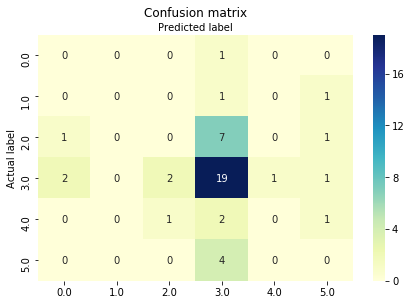

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.00      0.00      0.00         2
         2.0       0.00      0.00      0.00         9
         3.0       0.56      0.76      0.64        25
         4.0       0.00      0.00      0.00         4
         5.0       0.00      0.00      0.00         4

   micro avg       0.42      0.42      0.42        45
   macro avg       0.09      0.13      0.11        45
weighted avg       0.31      0.42      0.36        45



Tested Model:  xgb_clf


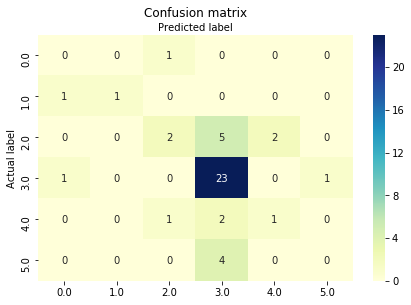

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       1.00      0.50      0.67         2
         2.0       0.50      0.22      0.31         9
         3.0       0.68      0.92      0.78        25
         4.0       0.33      0.25      0.29         4
         5.0       0.00      0.00      0.00         4

   micro avg       0.60      0.60      0.60        45
   macro avg       0.42      0.32      0.34        45
weighted avg       0.55      0.60      0.55        45



Tested Model:  sv_clf


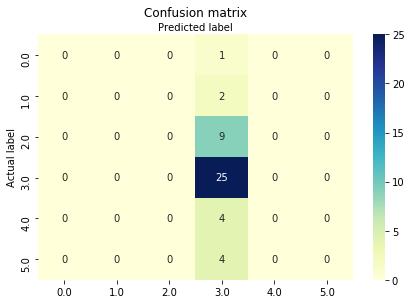

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.00      0.00      0.00         2
         2.0       0.00      0.00      0.00         9
         3.0       0.56      1.00      0.71        25
         4.0       0.00      0.00      0.00         4
         5.0       0.00      0.00      0.00         4

   micro avg       0.56      0.56      0.56        45
   macro avg       0.09      0.17      0.12        45
weighted avg       0.31      0.56      0.40        45





In [20]:
# Bellow, we train our pre-selected baseline models on our train dataset and display the scoring output.
for model in tested_models:
    pipe = BasePipeline(tested_models[model])
    pipe.fit(X_train, y_train)

    y_hat_test = pipe.predict(X_test)

    print('======================')
    print('Tested Model: ', model)
    print('======================')
    rpt.print_confusion_matrix(y_test, y_hat_test)
    print('\n')

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

lr = LogisticRegression()
dt_cls = DecisionTreeClassifier()
rf_clf = RandomForestClassifier()
adaboost_clf = AdaBoostClassifier()
knn_clf = KNeighborsClassifier()
xgb_clf = XGBClassifier()
sv_clf = SVC()

In [36]:
sorted(y.unique())

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
Tested Model:  model
              precision    recall  f1-score   support

         0.0       0.14      0.08      0.10        13
         1.0       1.00      0.40      0.57         5
         2.0       0.34      0.60      0.43        25
         3.0       0.52      0.65      0.58        46
         4.0       0.12      0.08      0.10        13
         5.0       1.00      0.06      0.11        18

   micro avg       0.42      0.42      0.42       120
   macro avg       0.52      0.31      0.31       120
weighted avg       0.49      0.42      0.37       120



Tested Model:  model
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        13
         1.0       1.00      1.00      1.00         5
         2.0       0.77      0.40      0.53        25
         3.0       0.69      0.98      0.81        46
         4.0       0.18      0.23      0.20        13
         5.0       0.00   

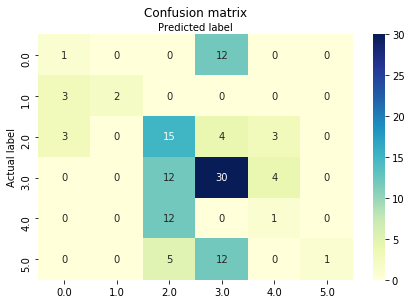

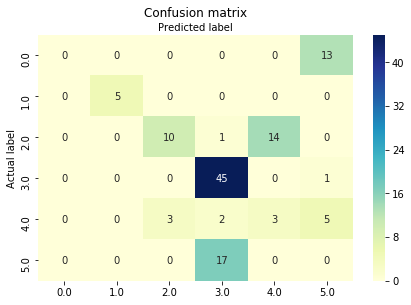

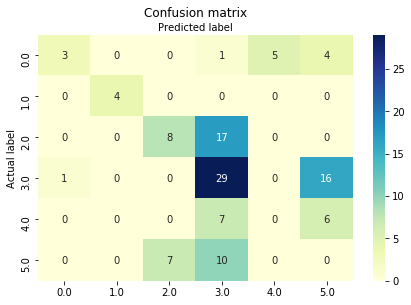

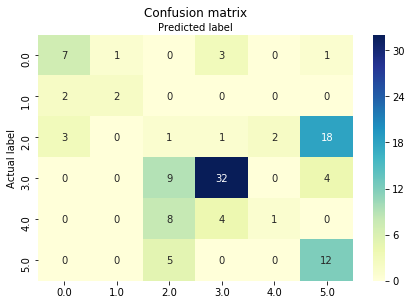

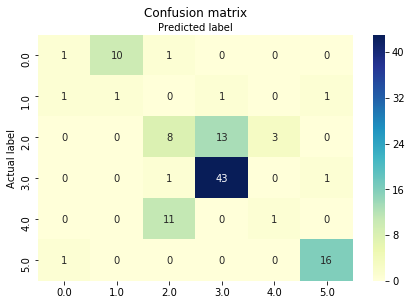

In [44]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
# X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
# y = np.array([0, 0, 1, 1])
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)

classes = sorted(y.unique())
print(skf)  

for train_index, test_index in skf.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    lr = LogisticRegression(penalty='l2')

    pipe = BasePipeline(lr)
    pipe.fit(X_train, y_train)

    y_hat_test = pipe.predict(X_test)

    print('======================')
    print('Tested Model: ', 'model')
    print('======================')
    print(classification_report(y_test, y_hat_test))
    mdt.print_confusion_matrix(y_test, y_hat_test, classes)
    print('\n')

In [22]:
# Changing target values to have a binary classifier
binary_y = y >= 3
binary_y = binary_y.astype(int)

5
StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
Tested Model:  model
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.64      1.00      0.78        76

   micro avg       0.64      0.64      0.64       118
   macro avg       0.32      0.50      0.39       118
weighted avg       0.41      0.64      0.50       118



Tested Model:  model
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.64      1.00      0.78        76

   micro avg       0.64      0.64      0.64       118
   macro avg       0.32      0.50      0.39       118
weighted avg       0.41      0.64      0.50       118



Tested Model:  model
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.64      1.00      0.78        76

   micro avg       0.64      0.64      0.64       1

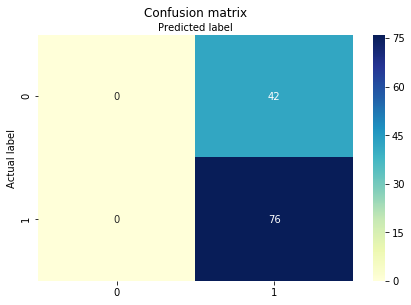

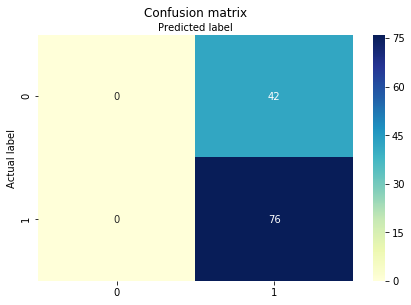

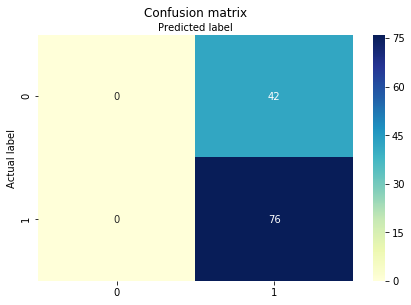

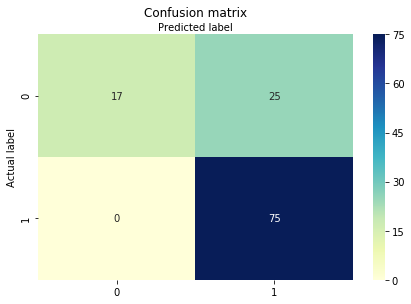

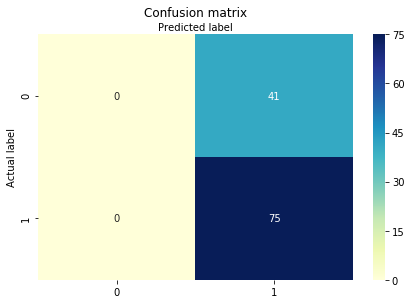

In [55]:
skf = StratifiedKFold(n_splits=5)
print(skf.get_n_splits(X, binary_y))

print(skf)

for train_index, test_index in skf.split(X, binary_y):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = binary_y[train_index], binary_y[test_index]
    
    lr = AdaBoostClassifier(n_estimators=5, learning_rate=0.01)

    pipe = BasePipeline(lr)
    pipe.fit(X_train, y_train)

    y_hat_test = pipe.predict(X_test)

    print('======================')
    print('Tested Model: ', 'model')
    print('======================')
    print(classification_report(y_test, y_hat_test))
    mdt.print_confusion_matrix(y_test, y_hat_test)
    print('\n')

In [11]:
from sklearn.model_selection import KFold
# X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
# y = np.array([1, 2, 3, 4])
kf = KFold(n_splits=5, random_state=42)
# kf.get_n_splits(X)

# print(kf)  

# KFold(n_splits=10, random_state=None, shuffle=False)

for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lr = SVC()

    pipe = BasePipeline(lr)
    pipe.fit(X_train, y_train)

    y_hat_test = pipe.predict(X_test)

    print('======================')
    print('Tested Model: ', 'model')
    print('======================')
    print(classification_report(y_test, y_hat_test))
    # print_confusion_matrix(y_test, y_hat_test)
    print('\n')


Tested Model:  model
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        35
         2.0       0.45      0.19      0.26        27
         3.0       0.32      0.94      0.48        35
         4.0       0.00      0.00      0.00        21
         5.0       0.00      0.00      0.00         0

   micro avg       0.32      0.32      0.32       118
   macro avg       0.15      0.23      0.15       118
weighted avg       0.20      0.32      0.20       118



Tested Model:  model
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        20
         2.0       0.44      0.17      0.25        23
         3.0       0.30      1.00      0.46        32
         4.0       0.00      0.00      0.00        43
         5.0       0.00      0.00      0.00         0

   micro avg       0.31      0.31      0.31       118
   macro avg       0.15      0.23      0.14       118
weighted avg       0.17      0.31

In [32]:
# Changing target values to have a binary classifier
new_y = y >= 3
y = new_y.astype(int)

In [47]:
y.sum()/len(y)

0.6439522998296422

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

lr = LogisticRegression()

pipe = BasePipeline(lr)
pipe.fit(X_train, y_train)

y_hat_test = pipe.predict(X_test)

print('======================')
print('Tested Model: ', 'model')
print('======================')
print(classification_report(y_test, y_hat_test))
# print_confusion_matrix(y_test, y_hat_test)
print('\n')

Tested Model:  model
              precision    recall  f1-score   support

           0       0.71      0.37      0.48        65
           1       0.71      0.91      0.80       112

   micro avg       0.71      0.71      0.71       177
   macro avg       0.71      0.64      0.64       177
weighted avg       0.71      0.71      0.68       177





In [48]:
from sklearn.model_selection import KFold
# X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
# y = np.array([1, 2, 3, 4])
kf = KFold(n_splits=4, random_state=123)
# kf.get_n_splits(X)

# print(kf)  

# KFold(n_splits=10, random_state=None, shuffle=False)

for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lr = LogisticRegression()

    pipe = BasePipeline(lr)
    pipe.fit(X_train, y_train)

    y_hat_test = pipe.predict(X_test)

    print('======================')
    print('Tested Model: ', 'model')
    print('======================')
    print(classification_report(y_test, y_hat_test))
    # print_confusion_matrix(y_test, y_hat_test)
    print('\n')


Tested Model:  model
              precision    recall  f1-score   support

           0       0.40      0.25      0.31        64
           1       0.55      0.71      0.62        83

   micro avg       0.51      0.51      0.51       147
   macro avg       0.48      0.48      0.46       147
weighted avg       0.49      0.51      0.48       147



Tested Model:  model
              precision    recall  f1-score   support

           0       0.68      0.80      0.73        45
           1       0.90      0.83      0.87       102

   micro avg       0.82      0.82      0.82       147
   macro avg       0.79      0.82      0.80       147
weighted avg       0.84      0.82      0.83       147



Tested Model:  model
              precision    recall  f1-score   support

           0       0.07      0.11      0.09        28
           1       0.77      0.69      0.73       119

   micro avg       0.58      0.58      0.58       147
   macro avg       0.42      0.40      0.41       147
weighte